In [159]:
import init

#from analisys.bkt_analisys import *
#from analisys.data_analisys import *
#from analisys.graph_analisys import *
#from analisys.optmizer_analisys import *
'''
fazer relatorio ano a ano com diferentes tipos de alavancagem. 


'''

import pandas as pd
import seaborn as sb
import random
import os

from backend.resampler import *
from backend.mt5_tools import *

from statsmodels.tsa.stattools import adfuller
from analisys.graph_analisys import moving_avg

import pyfolio as pf
from datetime import datetime
import time
from scipy.stats import pearsonr

sb.set_theme()
%matplotlib inline

In [175]:
df_14bis = pd.read_excel('forest[(10, 150), (0, 5), (-5, 0), (-1, 0), (0, 1), (700, 3000), (25, 50), (-300, 0)]ba6f_l554522roi1000305_2018.11.15x2021.05.15.xls', index_col=0)
df_14bis.keys()

Index(['date0', 'date1', 'x', 'y', 'Profit', 'Long', 'Short', 'n', 'Roi',
       'expo', 'PPP', 'SR', 'PL', 'std', 'VaR90', 'VaR95', 'VaR99', 'psize_x',
       'psize_y', 's_spread', 'l_spread', 'tp_short', 'tp_long', 'stop_return',
       'stop_number', 'days', 'period', 'p_size', 'test_returns',
       'train_returns', 'stop_numb'],
      dtype='object')

In [176]:

def data_format(df_14bis, cap=100000):
    date0 = []
    date1 = [] 
    for i in df_14bis['date0']:
        date0.append(datetime.strptime(i.replace('.', '-'), '%Y-%m-%d %H:%M:%S')) 
    for i in df_14bis['date1']:
        date1.append(datetime.strptime(i.replace('.', '-'), '%Y-%m-%d %H:%M:%S'))
    
    df_14bis['date0'] = date0
    df_14bis['date1'] = date0

    try:
        df_14bis = df_14bis.drop(columns=['stop_number'])
    except:
        pass

    return df_14bis

def strtolist(strlist):
    res = strlist.strip('][').split(', ')
    res = np.array(res, dtype=float)
    return res

df_14bis = data_format(df_14bis)
len(df_14bis)


2900

In [162]:
raw_treturns = df_14bis['test_returns']
e_list = df_14bis['expo']
roi_list = df_14bis['Roi']

t_returns = []

for r in raw_treturns:
    try:
        t_returns.append(strtolist(r))
    except:
        t_returns.append(np.array([0]))

_prof = []

for i in t_returns:
    try:
        _prof.append(sum(i))
    except:
        _prof.append(np.array([0]))

returns = {'expo': e_list,'returns':t_returns, 'roi':roi_list, 'profit':_prof}

returns = pd.DataFrame(returns)
#print(len(returns['expo']), len(returns['returns']), len(returns['roi']), len(returns['profit']))



In [177]:
df_14bis[:5]

,date0,date1,x,y,Profit,Long,Short,n,Roi,expo,...,l_spread,tp_short,tp_long,stop_return,days,period,p_size,test_returns,train_returns,stop_numb
0,2019-01-04 10:00:00,2019-01-04 10:00:00,IGTA3,BBAS3,-650.0,-560.0,-90.0,1,-0.007651,84960.0,...,-5,-1,0,-256,6,37,[1000],[-650.0000000000057],"[309.99999999999517, -70.00000000000028, 60.00...",47
1,2019-01-04 10:00:00,2019-01-04 10:00:00,B3SA3,SULA11,-500.0,70.0,-570.0,1,-0.009862,50700.0,...,-1,-1,0,-177,6,95,[1000],[-499.99999999999994],"[119.99999999999744, 999.9999999999965, 49.999...",37
2,2019-01-04 10:00:00,2019-01-04 10:00:00,BBDC4,BPAC11,35.0,45.0,-10.0,1,0.000676,51773.0,...,-4,-1,0,-138,6,46,[1000],[34.999999999999076],"[-37.99999999999919, 265.99999999999966, 512.9...",40
3,2019-01-04 10:00:00,2019-01-04 10:00:00,MULT3,BBDC3,0.0,0.0,0.0,0,0.000000,0.0,...,-1,-1,1,-30,6,84,[1000],0,0,25
4,2019-01-04 10:00:00,2019-01-04 10:00:00,BBSE3,BRML3,248.0,-188.0,436.0,11,0.009446,26254.0,...,0,0,1,-290,6,66,[1000],"[-27.999999999998337, 464.00000000000114, 5.99...","[91.9999999999991, -54.000000000000625, 136.00...",50


--------------------------------------------------
tp : 214
sl : 598
na : 260


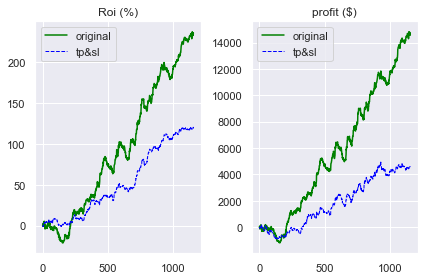

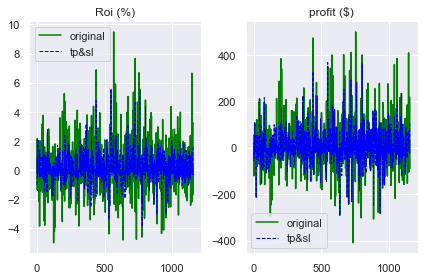

In [179]:
new_returns = {'returns':[], 'roi':[], 'profit':[]}
percentage = []

tp_n = 0
sl_n = 0
na_n = 0

tp = 0.008
sl = -0.0002

print('-'*50)
for i in range(len(returns['roi'])):
    r = returns['roi'][i]
    for j in range(len(returns['returns'][i])):   
       
        _expo = returns['expo'][i]

        if(_expo > 0):
            
            r_partial = sum(returns['returns'][i][:j])/_expo
            
            if(r_partial > tp):
                tp_n += 1
                percentage.append(j/len(returns['returns']))
                new_returns['returns'].append(returns['returns'][i][:j])
                new_returns['profit'].append(sum(returns['returns'][i][:j]))  #profit
                #new_returns['profit'].append(_expo*r_partial)
                new_returns['roi'].append(r_partial)
                break

            elif(r_partial < sl):
                sl_n += 1
                percentage.append(j/len(returns['returns']))
                new_returns['returns'].append(returns['returns'][i][:j])
                new_returns['profit'].append(sum(returns['returns'][i][:j]))  #profit
                #new_returns['profit'].append(_expo*r_partial)
                new_returns['roi'].append(r_partial)
                break
            elif(j == len(returns['returns'][i])-1):
                na_n += 1
                percentage.append(j/len(returns['returns']))
                new_returns['returns'].append(returns['returns'][i])
                new_returns['profit'].append(sum(returns['returns'][i]))  #profit
                #new_returns['profit'].append(_expo*r_partial) 

                new_returns['roi'].append(r_partial)
                break

        elif(_expo <= 0):
            percentage.append(0)
            new_returns['returns'].append(0)
            new_returns['profit'].append(0) 
            new_returns['roi'].append(0)
            
                  
        

new_returns = pd.DataFrame(new_returns)
[len(new_returns['returns']), len(new_returns['roi']), len(new_returns['profit'])], [len(returns['returns']), len(returns['roi']), len(returns['profit'])]
print('tp : {}\nsl : {}\nna : {}'.format(tp_n, sl_n, na_n))

plt.figure()

plt.subplot(121)
plt.title('Roi (%)')
plt.plot(np.cumsum(returns['roi']*100), color='green', label = 'original')
plt.plot(np.cumsum(new_returns['roi']*100), color='blue', linestyle='dashed', linewidth=1, label= 'tp&sl')
plt.legend()

plt.subplot(122)
plt.title('profit ($)')
plt.plot(np.cumsum(returns['profit']), color='green', label='original')
plt.plot(np.cumsum(new_returns['profit']), color='blue', linestyle='dashed', linewidth=1, label = 'tp&sl')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure()

plt.subplot(121)
plt.title('Roi (%)')
plt.plot((returns['roi']*100), color='green', label = 'original')
plt.plot((new_returns['roi']*100), color='blue', linestyle='dashed', linewidth=1, label= 'tp&sl')
plt.legend()

plt.subplot(122)
plt.title('profit ($)')
plt.plot((returns['profit']), color='green', label='original')
plt.plot((new_returns['profit']), color='blue', linestyle='dashed', linewidth=1, label = 'tp&sl')
plt.legend()

plt.tight_layout()
plt.show()

--------------------------------------------------
tp : 10
sl : 472
na : 590


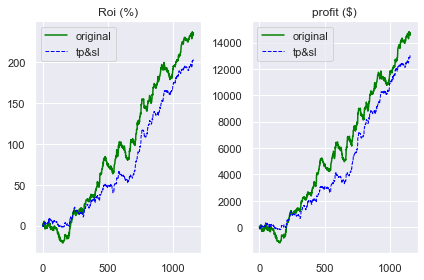

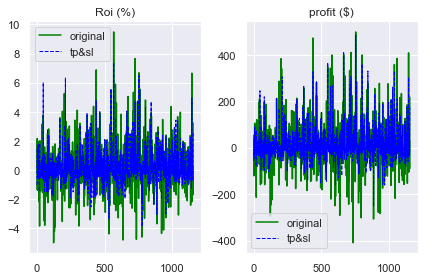

In [180]:
new_returns = {'returns':[], 'roi':[], 'profit':[]}
percentage = []

tp_n = 0
sl_n = 0
na_n = 0

tp = 300
sl = -10

print('-'*50)
for i in range(len(returns['roi'])):
    r = returns['profit'][i]
    for j in range(len(returns['returns'][i])):   
       
        _expo = returns['expo'][i]

        if(_expo > 0):
            
            r_partial = sum(returns['returns'][i][:j])
            
            if(r_partial > tp):
                tp_n += 1
                percentage.append(j/len(returns['returns']))
                new_returns['returns'].append(returns['returns'][i][:j])
                new_returns['profit'].append(r_partial)  #profit
                #new_returns['profit'].append(_expo*r_partial)
                new_returns['roi'].append(r_partial/_expo)
                break

            elif(r_partial < sl):
                sl_n += 1
                percentage.append(j/len(returns['returns']))
                new_returns['returns'].append(returns['returns'][i][:j])
                new_returns['profit'].append(r_partial)  #profit
                #new_returns['profit'].append(_expo*r_partial)
                new_returns['roi'].append(r_partial/_expo)
                break
            elif(j == len(returns['returns'][i])-1):
                na_n += 1
                percentage.append(j/len(returns['returns']))
                new_returns['returns'].append(returns['returns'][i])
                new_returns['profit'].append(r_partial)  #profit
                #new_returns['profit'].append(_expo*r_partial) 

                new_returns['roi'].append(r_partial/_expo)
                break

        elif(_expo <= 0):
            percentage.append(0)
            new_returns['returns'].append(0)
            new_returns['profit'].append(0) 
            new_returns['roi'].append(0)
            
                  
        

new_returns = pd.DataFrame(new_returns)
[len(new_returns['returns']), len(new_returns['roi']), len(new_returns['profit'])], [len(returns['returns']), len(returns['roi']), len(returns['profit'])]
print('tp : {}\nsl : {}\nna : {}'.format(tp_n, sl_n, na_n))

plt.figure()

plt.subplot(121)
plt.title('Roi (%)')
plt.plot(np.cumsum(returns['roi']*100), color='green', label = 'original')
plt.plot(np.cumsum(new_returns['roi']*100), color='blue', linestyle='dashed', linewidth=1, label= 'tp&sl')
plt.legend()

plt.subplot(122)
plt.title('profit ($)')
plt.plot(np.cumsum(returns['profit']), color='green', label='original')
plt.plot(np.cumsum(new_returns['profit']), color='blue', linestyle='dashed', linewidth=1, label = 'tp&sl')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure()

plt.subplot(121)
plt.title('Roi (%)')
plt.plot((returns['roi']*100), color='green', label = 'original')
plt.plot((new_returns['roi']*100), color='blue', linestyle='dashed', linewidth=1, label= 'tp&sl')
plt.legend()

plt.subplot(122)
plt.title('profit ($)')
plt.plot((returns['profit']), color='green', label='original')
plt.plot((new_returns['profit']), color='blue', linestyle='dashed', linewidth=1, label = 'tp&sl')
plt.legend()

plt.tight_layout()
plt.show()